# This is a notebook to demonstrate how the tf-idf combined with an Autoencoder approach can be used to convert album reviews into 3 dimensional points in space.

In [2]:


import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
from torch.autograd import Variable

from torch import nn
%matplotlib notebook



In [243]:
# Here we read in the data and take just the columns we are interested in

data = pd.read_csv('../media/pitchfork_reviews.csv', error_bad_lines=False);
data_text = data[['artist', 'title', 'content', 'score']]
documents = data_text
documents = documents.dropna(subset=['content']).reset_index(drop=True)
good_reviews = documents[documents['score'] > 8.0]


<IPython.core.display.Javascript object>


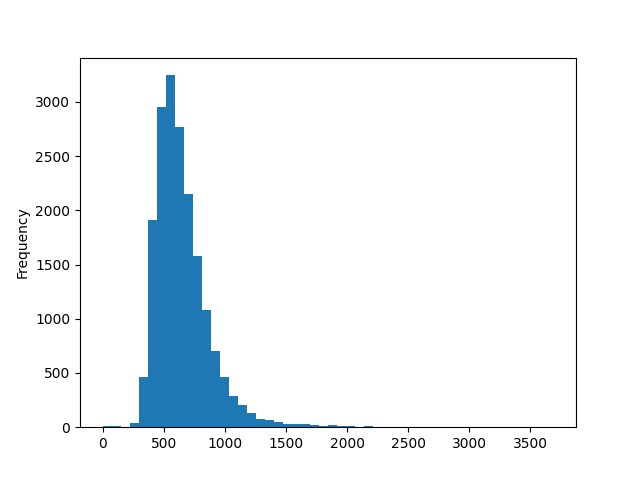

<AxesSubplot:ylabel='Frequency'>

In [82]:
# Before selecting how many features to select using the tf-idf vectorizer, check how long reviews are.

documents['len_review'] = [len(item) for item in documents['content'].str.split()]
documents['len_review'].plot.hist(bins=50)

In [74]:
# Here we can see that the reviews have a mean of 650 words and the distribution of number of words is positively skewed.
# We take 650 as the goal number of features to use in the tf-idf vectorization

In [59]:
tfidf = TfidfVectorizer(max_features=1000,
                        lowercase=True,
                        analyzer='word',
                        stop_words='english',
                        ngram_range=(1,1))

dat_tfIdf = tfidf.fit_transform(list(documents['content'].values))

In [20]:
# This is what the features extracted from the data look like.

tfidf_tokens = tfidf.get_feature_names()
print(tfidf_tokens)

['10', '12', '20', '70s', '80s', '90s', 'able', 'acoustic', 'act', 'acts', 'actual', 'actually', 'aesthetic', 'age', 'ago', 'air', 'album', 'albums', 'ambient', 'american', 'apart', 'approach', 'aren', 'arrangements', 'art', 'artist', 'artists', 'aside', 'atmosphere', 'attention', 'audience', 'away', 'baby', 'background', 'backing', 'bad', 'ballad', 'band', 'bands', 'barely', 'based', 'bass', 'bassist', 'beat', 'beats', 'beautiful', 'begins', 'believe', 'best', 'better', 'big', 'bit', 'black', 'blood', 'blue', 'blues', 'body', 'born', 'box', 'boy', 'boys', 'break', 'brief', 'bright', 'bring', 'british', 'broken', 'build', 'building', 'built', 'called', 'came', 'career', 'case', 'catchy', 'cd', 'certain', 'certainly', 'chance', 'change', 'chords', 'chorus', 'city', 'classic', 'clear', 'clearly', 'close', 'closer', 'club', 'cold', 'collaboration', 'collection', 'collective', 'come', 'comes', 'coming', 'compilation', 'complete', 'completely', 'concept', 'context', 'cool', 'country', 'coup

In [21]:
df_countvect = pd.DataFrame(data=dat_tfIdf.toarray(),
                            index=documents['title'],
                            columns=tfidf_tokens)

In [60]:
# Here is what the tf-idf vectorization looks like. Each album has an associated 1000-dim vector that can be used to describe it.

df_countvect.head()

,10,12,20,70s,80s,90s,able,acoustic,act,acts,...,write,writing,written,wrong,year,years,yes,york,young,youth
title,,,,,,,,,,,,,,,,,,,,,
mezzanine,0.100228,0.0,0.0,0.112511,0.054102,0.201975,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.064036,0.116462,0.0,0.000000,0.043668,0.000000
prelapsarian,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.066546,0.0,0.121788,0.000000,0.000000
all of them naturals,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.042504,0.000000,0.0,0.000000,0.000000,0.000000
first songs,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.055768,0.0,0.102103,0.000000,0.0,0.000000,0.000000,0.063152
new start,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.155721,0.0,0.0,0.0,...,0.0,0.075472,0.000000,0.0,0.000000,0.041268,0.0,0.000000,0.000000,0.000000


In [62]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1000, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), nn.Linear(64, 12), nn.ReLU(True), nn.Linear(12, 3))
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True), nn.Linear(256, 1000), nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [89]:
num_epochs = 100
batch_size = 128
dataset = torch.from_numpy(dat_tfIdf.toarray())
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [90]:
for epoch in range(num_epochs):
    for data in dataloader:
        album  = data.float()
        # ===================forward=====================
        output = model(album)
        loss = criterion(output, album)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.data))

epoch [1/100], loss:0.0009
epoch [2/100], loss:0.0009
epoch [3/100], loss:0.0009
epoch [4/100], loss:0.0009
epoch [5/100], loss:0.0009
epoch [6/100], loss:0.0009
epoch [7/100], loss:0.0009
epoch [8/100], loss:0.0009
epoch [9/100], loss:0.0009
epoch [10/100], loss:0.0009
epoch [11/100], loss:0.0009
epoch [12/100], loss:0.0009
epoch [13/100], loss:0.0008
epoch [14/100], loss:0.0008
epoch [15/100], loss:0.0008
epoch [16/100], loss:0.0008
epoch [17/100], loss:0.0008
epoch [18/100], loss:0.0008
epoch [19/100], loss:0.0008
epoch [20/100], loss:0.0008
epoch [21/100], loss:0.0008
epoch [22/100], loss:0.0008
epoch [23/100], loss:0.0008
epoch [24/100], loss:0.0008
epoch [25/100], loss:0.0008
epoch [26/100], loss:0.0008
epoch [27/100], loss:0.0008
epoch [28/100], loss:0.0008
epoch [29/100], loss:0.0008
epoch [30/100], loss:0.0008
epoch [31/100], loss:0.0008
epoch [32/100], loss:0.0008
epoch [33/100], loss:0.0008
epoch [34/100], loss:0.0008
epoch [35/100], loss:0.0008
epoch [36/100], loss:0.0008
e

In [91]:
encoded_reviews = model.encoder(dataset.float())

In [179]:
X = encoded_reviews.detach().numpy()

In [95]:
sample_docs = documents[(documents['artist']=='kanye west' )| (documents['artist']=='kendrick lamar') | (documents['artist']=='coldplay') | (documents['artist']=='ariana grande')]
sample_docs

,artist,title,content,len_review
769,ariana grande,dangerous woman,"“You need a bad girl to blow your mind,” Arian...",903
1046,kendrick lamar,untitled unmastered.,"""I made To Pimp a Butterfly for you,"" raps Ken...",855
1126,kanye west,the life of pablo,Pablo Picasso and Kanye West share many qualit...,2071
1306,coldplay,a head full of dreams,On the very first song on their very first alb...,911
2171,kendrick lamar,to pimp a butterfly,Kendrick Lamar’s major-label albums play out l...,847
2767,ariana grande,my everything,The debut album from Nickelodeon star-turned-p...,885
3092,coldplay,ghost stories,"""If you could see it, then you'd understand."" ...",1119
3857,ariana grande,yours truly,"Ariana Grande, a teenage actress turned singer...",665
4180,kanye west,yeezus,"Look at the song title ""I Am a God"" and it see...",1556
4955,kendrick lamar,"good kid, m.a.a.d city","The first sound we hear on good kid, m.A.A.d. ...",932


In [96]:
sample_docs['artist'] = sample_docs['artist'].astype('category')

<ipython-input-96-528f35cdc122>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_docs['artist'] = sample_docs['artist'].astype('category')


<IPython.core.display.Javascript object>


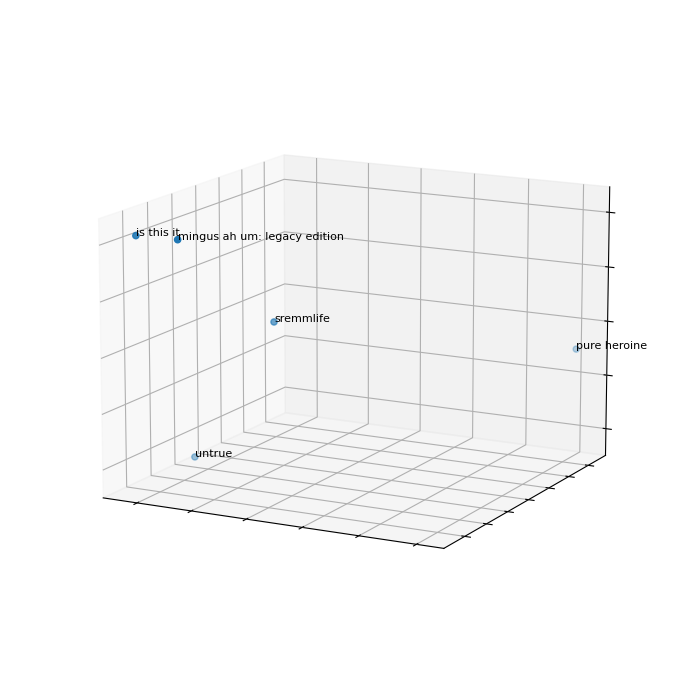

In [142]:
sample_doc_encoded = np.asarray([X[item] for item in sample_docs.index])
album_list = list(sample_docs['artist'].values)
fig = plt.figure(1, figsize=(7, 7))
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=48, azim=134)

ax.scatter(sample_doc_encoded[:, 0], sample_doc_encoded[:, 1], sample_doc_encoded[:, 2],
           c=np.array(sample_docs['artist'].cat.codes).astype(np.float))

for i, txt in enumerate(album_list):
    ax.text(sample_doc_encoded[i, 0], sample_doc_encoded[i, 1], sample_doc_encoded[i, 2], txt, fontsize=8)
    
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.dist = 12

In [230]:
check_albums = documents[(documents['artist']=='kendrick lamar' )| (documents['artist']=='radiohead') | (documents['artist']=='the gaslight anthem') | (documents['artist']=='run the jewels')]
documents[documents['artist'] == 'the beatles']

,artist,title,content,score
3671,the beatles,on air - live at the bbc vol. 2,The Beatles mythos is a sum of historic locati...,7.2
8615,the beatles,the beatles,"In his review of the Beatles' 1963 LP debut, P...",10.0
8616,the beatles,yellow submarine,"Hey, nobody's perfect. The only truly minor al...",6.2
8617,the beatles,abbey road,"One more ""like we used to"" was how Paul McCart...",10.0
8618,the beatles,let it be,"As the 1960s wound down, so did the Beatles. T...",9.1
8619,the beatles,past masters,Past Masters is the ugly but brilliant siblin...,9.2
8620,the beatles,rubber soul,"To modern ears, Rubber Soul and its pre-psyche...",10.0
8621,the beatles,revolver,"Like any band, the Beatles' recording career w...",10.0
8622,the beatles,sgt. pepper's lonely hearts club band,"Finally free of touring, the Beatles next soug...",10.0
8623,the beatles,magical mystery tour,"After the death of manager Brian Epstein, the ...",10.0


In [194]:
check_albums

,artist,title,content,len_review
11,run the jewels,run the jewels 3,"On 2006’s “That’s Life,” Killer Mike boasted “...",823
818,radiohead,a moon shaped pool,"Radiohead, who titled their ninth studio album...",1124
1046,kendrick lamar,untitled unmastered.,"""I made To Pimp a Butterfly for you,"" raps Ken...",855
1511,run the jewels,meow the jewels,Cats are the Internet's favorite pets for many...,868
2171,kendrick lamar,to pimp a butterfly,Kendrick Lamar’s major-label albums play out l...,847
2557,run the jewels,run the jewels 2,Trigger warning: If you or someone you love is...,1894
2803,the gaslight anthem,get hurt,Who says the Gaslight Anthem doesn’t have a se...,997
4135,run the jewels,run the jewels,Even for those of us who go all the way back t...,1091
4955,kendrick lamar,"good kid, m.a.a.d city","The first sound we hear on good kid, m.A.A.d. ...",932
5252,the gaslight anthem,handwritten,Brian Fallon doesn't seem like the kind of guy...,671


In [235]:
albums_i_like = ['run the jewels 2', 'to pimp a butterfly', 'in rainbows', 'american slang']
albums_i_like_idx= list(documents[documents.title.isin(albums_i_like)].index)
list_of_points = []

for index in albums_i_like_idx:
    list_of_points.append(X[index])

list_of_points

[array([-0.45591772, -0.01160568,  0.02992859], dtype=float32),
 array([-0.9018583 ,  0.01481776,  0.07123911], dtype=float32),
 array([-0.07373562, -0.6009283 , -1.0763252 ], dtype=float32),
 array([-0.10259155, -0.9931934 , -1.1196787 ], dtype=float32)]

In [252]:
mean_point = np.mean(list_of_points, axis=0)

from scipy.stats import gmean
g_mean_point = gmean(list_of_points, axis=0)
list_of_points.append(g_mean_point)
X_test = np.asarray(list_of_points)
g_mean_point

[array([-0.1511252 , -0.1366487 , -0.37766623], dtype=float32),
 array([-1.2165605, -1.4816178, -0.8945276], dtype=float32),
 array([-0.31573698, -0.11191535, -0.37040484], dtype=float32),
 array([-0.19224234, -0.5060732 , -1.2371645 ], dtype=float32),
 array([-0.46891627, -0.55906373, -0.7199408 ], dtype=float32),
 array([-0.46891627, -0.55906373, -0.7199408 ], dtype=float32),
 array([-0.46891627, -0.55906373, -0.7199407 ], dtype=float32),
 array([nan, nan, nan], dtype=float32),
 array([nan, nan, nan], dtype=float32),
 array([nan, nan, nan], dtype=float32),
 array([nan, nan, nan], dtype=float32),
 array([nan, nan, nan], dtype=float32)]

In [238]:
def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return np.argmin(dist_2)

In [200]:
documents[documents.title.isin(albums_i_like)]

,artist,title,content,len_review
2171,kendrick lamar,to pimp a butterfly,Kendrick Lamar’s major-label albums play out l...,847
2557,run the jewels,run the jewels 2,Trigger warning: If you or someone you love is...,1894
7711,the gaslight anthem,american slang,Where so many young rock bands struggle to lib...,564
10877,radiohead,in rainbows,"Like many music lovers of a certain age, I hav...",1221


In [249]:
closest_node(mean_point, good_reviews_data)

0

In [242]:
documents.iloc[2390]

artist                                          rae sremmurd
title                                              sremmlife
content    Last year, buoyed by effervescent hits like th...
score                                                    7.8
Name: 2390, dtype: object

In [244]:
album_list = albums_i_like + ['sremmlife']
sample_doc_encoded = np.asarray([X[item] for item in sample_docs.index])
fig = plt.figure(1, figsize=(7, 7))
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=48, azim=134)

ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2])

for i, txt in enumerate(album_list):
    ax.text(X_test[i, 0], X_test[i, 1], X_test[i, 2], txt, fontsize=8)
    
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.dist = 12

In [218]:
albums_list

['run the jewels 2',
 'to pimp a butterfly',
 'in rainbows',
 'american slang',
 'puerto muerto']

In [240]:
good_reviews_data = [X[i] for i in good_reviews.index]

In [254]:
albums_i_like = ['is this it', 'pure heroine', 'mingus ah um: legacy edition', 'untrue']
albums_i_like_idx= list(documents[documents.title.isin(albums_i_like)].index)
list_of_points = []

for index in albums_i_like_idx:
    list_of_points.append(X[index])

list_of_points
mean_point = np.mean(list_of_points, axis=0)

from scipy.stats import gmean
g_mean_point = gmean(list_of_points, axis=0)
list_of_points.append(g_mean_point)
X_test = np.asarray(list_of_points)


In [255]:
g_mean_point

array([nan, nan, nan], dtype=float32)

In [261]:
gmean([X_test[0]])

array([nan, nan, nan], dtype=float32)

In [262]:
X_test[0]

array([-0.1511252 , -0.1366487 , -0.37766623], dtype=float32)